In [1]:
import mlflow
import pandas as pd
import numpy as np
import os
from ruamel import yaml
import seaborn as sns
import matplotlib.pyplot as plt
dataset_name="jakson"
pred_target="ERStatus"
experiment_name = f"san_{dataset_name}_{pred_target}"
shared_path = "/Users/ast/Downloads/base_configs"
root_path_results = "/Users/ast/Downloads/results"
all_data_points = pd.DataFrame(columns=["exp_name", "exp_type", "test_balanced_accuracy"])

## Get data from MLFlow

In [2]:
gcl_exp_names = [
    "gcl_ER_concat",
    "gcl_ER_linear",
    "gcl_ER_transfromer",
    "gcl_ER_concat_end_to_end",
    "gcl_ER_linear_end_to_end",
    "gcl_ER_transfromer_end_to_end",
    "gcl_ER_concat_linear_probing",
    "gcl_ER_linear_linear_probing",
    "gcl_ER_transfromer_linear_probing",
]

In [3]:
for gcl_type in gcl_exp_names:
    p = os.path.join(shared_path, f"best_{gcl_type}.yaml")
    with open(p) as file:
        # The FullLoader parameter handles the conversion from YAML
        # scalar values to Python the dictionary format
        cfg = yaml.load(file, Loader=yaml.Loader)  # TODO: what is the Loader kwarg?

    run_type = "train_ER_gcl"
    exp_type = "ER"
    exp_name = gcl_type.replace("_ER","")
        
    # Define query for MLFlow
    query = f"""\
        params.split_strategy = "split_basel_leave_zurich_as_external" and \
        params.run_type = "{run_type}" and \
        params.agg_lr = "{cfg["agg_lr"][0]}" and \
        params.gnns_lr = "{cfg["gnns_lr"][0]}" and \
        params.aggregator = "{cfg["aggregator"][0]}" and \
        params.n_heads = "{cfg["n_heads"][0]}" and \
        params.depth = "{cfg["depth"][0]}" and \
        params.scaler = "{cfg["scaler"][0]}"
        """
    #query = 'params.dataset_name = "frequency_dataset" and params.run_type = "space_gm" and params.split_strategy = "split_basel_leave_zurich_as_external"'
    df = mlflow.search_runs(
            experiment_names=[experiment_name],
            filter_string=query,
    )
    df = df.drop(df[df.duplicated(subset=["params.seed"])].index.values[0])
    df = df.drop(df.loc[df["params.scheduler"] == f"{cfg['scheduler'][0]}"].index.values[0])
    d={"exp_name":f"{exp_name}", "exp_type":f"{exp_type}", "test_balanced_accuracy":df["metrics.test_best_val_balanced_accuracy_balanced_accuracy"]}
    all_data_points = pd.concat([all_data_points, pd.DataFrame(data=d)], ignore_index=True)

In [4]:
all_data_points.groupby("exp_name").describe()

test_balanced_accuracy                       
                                                count      mean       std   
exp_name                                                                    
gcl_concat                                      100.0  0.953246  0.013551  \
gcl_concat_end_to_end                            99.0  0.709809  0.072259   
gcl_concat_linear_probing                       100.0  0.790165  0.018413   
gcl_linear                                      100.0  0.939369  0.016509   
gcl_linear_end_to_end                            99.0  0.740043  0.042525   
gcl_linear_linear_probing                       100.0  0.778457  0.028876   
gcl_transfromer                                 100.0  0.944665  0.013834   
gcl_transfromer_end_to_end                      101.0  0.778796  0.029910   
gcl_transfromer_linear_probing                  100.0  0.774202  0.021304   

                                                                         
                                     min       25%       50%       75%   
exp_name                                                                 
gcl_concat                      0.911579  0.946548  0.953496  0.963036  \
gcl_concat_end_to_end           0.497854  0.688528  0.730955  0.752727   
gcl_concat_linear_probing       0.738019  0.780155  0.791622  0.804185   
gcl_linear                      0.898743  0.929810  0.940930  0.952581   
gcl_linear_end_to_end           0.549624  0.716246  0.745976  0.768509   
gcl_linear_linear_probing       0.719331  0.760841  0.777986  0.797747   
gcl_transfromer                 0.895159  0.934050  0.945883  0.953313   
gcl_transfromer_end_to_end      0.697872  0.758226  0.780579  0.799267   
gcl_transfromer_linear_probing  0.718705  0.761892  0.773247  0.787174   

                                          
                                     max  
exp_name                                  
gcl_concat                      0.975601  
gcl_concat_end_to_end           0.817060  
gcl_concat_linear_probing       0.821352  
gcl_linear                      0.974869  
gcl_linear_end_to_end           0.863644  
gcl_linear_linear_probing       0.850769  
gcl_transfromer                 0.982848  
gcl_transfromer_end_to_end      0.842185  
gcl_transfromer_linear_probing  0.848623

## Plot

In [5]:
sns.set_theme(style="whitegrid", palette="colorblind")
sns.set_context("paper")

In [6]:
order = np.array([
    'gcl_concat_end_to_end', 
    'gcl_linear_end_to_end',
    'gcl_transfromer_end_to_end', 
    'gcl_concat_linear_probing',
    'gcl_linear_linear_probing',
    'gcl_transfromer_linear_probing', 
    'gcl_linear', 
    'gcl_transfromer', 
    'gcl_concat'])
better_labels = np.char.title(np.char.replace(np.char.mod('%s', order), '_', ' '))
better_labels = np.char.replace(np.char.mod('%s', better_labels), 'Gcl', 'GCL')
better_labels

array(['GCL Concat End To End', 'GCL Linear End To End',
       'GCL Transfromer End To End', 'GCL Concat Linear Probing',
       'GCL Linear Linear Probing', 'GCL Transfromer Linear Probing',
       'GCL Linear', 'GCL Transfromer', 'GCL Concat'], dtype='<U30')

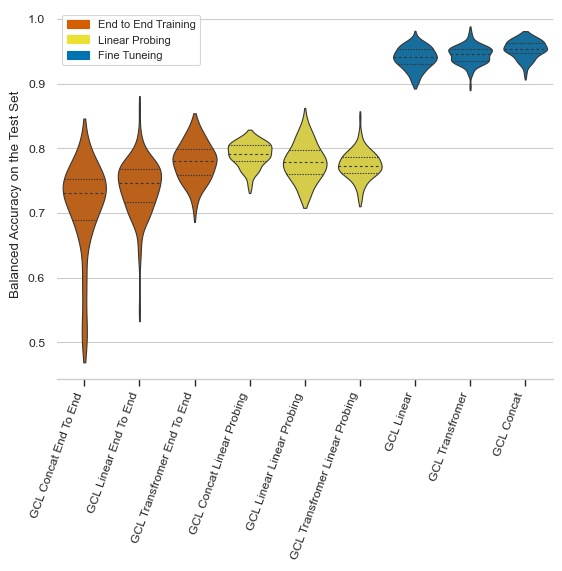

In [10]:
my_pal = {}
import matplotlib.patches as mpatches
for e_type in all_data_points["exp_name"].unique():
    if e_type in ["gcl_concat_end_to_end", "gcl_linear_end_to_end","gcl_transfromer_end_to_end"]:
        my_pal[e_type] = "r"
    elif e_type in ["gcl_concat_linear_probing", "gcl_linear_linear_probing","gcl_transfromer_linear_probing"]:
        my_pal[e_type] = "y"
    else:
        my_pal[e_type] = "b"
        
ax = sns.violinplot(
    linewidth = 0.8,
    data=all_data_points, 
    x="exp_name", 
    y="test_balanced_accuracy",
    order=order,
    cut=True,
    scale="count",
    palette=my_pal,
    inner="quartile"
)

ax.set_xticklabels(
    better_labels, 
    rotation=70,
    horizontalalignment='right'
)
ax.set(xlabel ="", ylabel = "Balanced Accuracy on the Test Set", title ='')
ax.tick_params(axis='x', which='both', bottom=True)
legend_handles = [
    mpatches.Patch(color='r', label='End to End Training'),
        mpatches.Patch(color='y', label='Linear Probing'),
    mpatches.Patch(color='b', label='Fine Tuneing'),
]
plt.legend(handles=legend_handles, loc='upper left', fontsize='small')
sns.despine(left=True)
path_to_file = os.path.join(root_path_results, "violin_plots_GCL_training_strategy.jpg")
plt.savefig(path_to_file, bbox_inches='tight', dpi=300)